In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset

Tiny Lego dataset
- https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [ ]:
if not os.path.exists("tiny_nerf_data.npz"):
  !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

dataset = np.load("tiny_nerf_data.npz")
print(dataset["images"].shape)
print(dataset["poses"].shape)
print(dataset['focal'])
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(30,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(dataset['images'][i])
    plt.title('Image: {}'.format(i+1))
    plt.axis("off")

# Data Loading (Pinhole Camera Model)




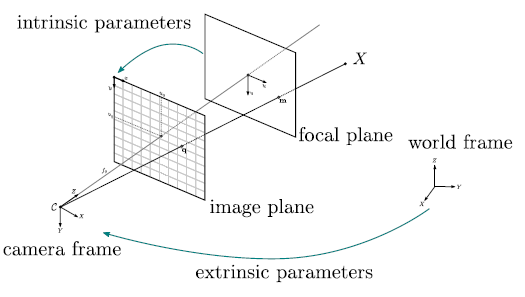

In [ ]:
poses = dataset['poses']
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, 3]

ax = plt.figure(figsize=(12,8)).add_subplot(projection="3d")
_ = ax.quiver(
    origins[..., 0].flatten(),
    origins[..., 1].flatten(),
    origins[..., 2].flatten(),
    dirs[..., 0].flatten(),
    dirs[..., 1].flatten(),
    dirs[..., 2].flatten(), length=0.5, normalize=True
)
plt.show()

# Functions

- get_rays


In [ ]:
def get_rays(h: int, w: int, focal_length: float, pose: torch.Tensor):
  i, j = torch.meshgrid(
      torch.arange(w, dtype=torch.float32).to(pose),
      torch.arange(h, dtype=torch.float32).to(pose),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  rays_d = torch.stack([(i - w * .5) / focal_length,
                            -(j - h * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)
  rays_d = torch.sum(rays_d[..., None, :] * pose[:3, :3], dim=-1)
  rays_o = pose[:3, -1].expand(rays_d.shape)
  return rays_o, rays_d


- stratified_sampling

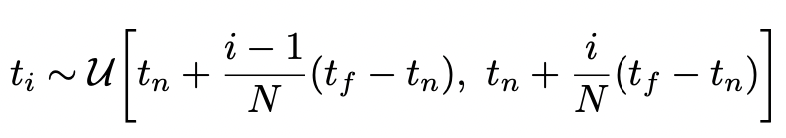


In [ ]:
def stratified_sampling(
    rays_o,
    rays_d,
    near,
    far,
    n,
):
  # shape: (num_samples)
  t = torch.linspace(near, far, n).to(rays_o)
  
  # ray_origins: (width, height, 3)
  # noise_shape = (width, height, num_samples)
  noise_shape = list(rays_o.shape[:-1]) + [n]
  
  # depth_values: (num_samples)
  t = t + torch.rand(noise_shape).to(rays_o) * (far - near) / n
  
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  x = rays_o[..., None, :] + rays_d[..., None, :] * t[..., :, None]
  
  return x, t

- positional encoding
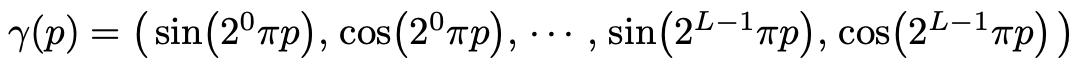

In [ ]:
def positional_encoding(
    x, L=6, include_input=True
) -> torch.Tensor:
  encoding = [x] if include_input else []
  frequency_bands = 2.0 ** torch.linspace(
        0.0,
        L - 1,
        L,
        dtype=x.dtype,
        device=x.device,
  )
  for freq in frequency_bands:
    encoding.append(torch.sin(x * freq * np.pi))
    encoding.append(torch.cos(x * freq * np.pi))
  
  return torch.cat(encoding, dim=-1)

- volume_rendering
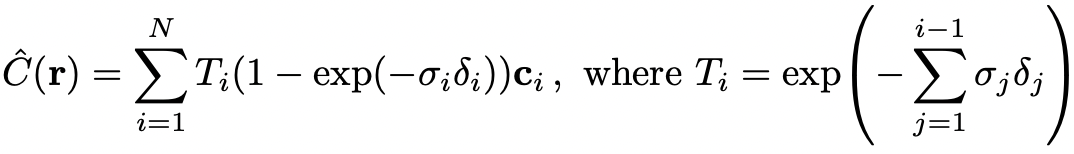

In [ ]:
## TODO 1.
def volume_rendering(c, sigma, rays_o, t):
  sigma = torch.nn.functional.relu(sigma)[...,0]
  c = torch.sigmoid(c)
  delta = t[..., 1:] - t[..., :-1]
  delta = torch.cat([delta, torch.tensor([1e10], dtype=rays_o.dtype, device=rays_o.device).expand(t[...,:1].shape)], dim=-1)

  alpha = 1. - torch.exp(-sigma * delta)
  T = torch.cumprod(1. - alpha + 1e-10, -1)
  T = torch.roll(T, 1, -1)
  T[..., 0] = 1.

  w = T * alpha

  rgb = (w[..., None] * c).sum(dim=-2)
  return rgb

# Model

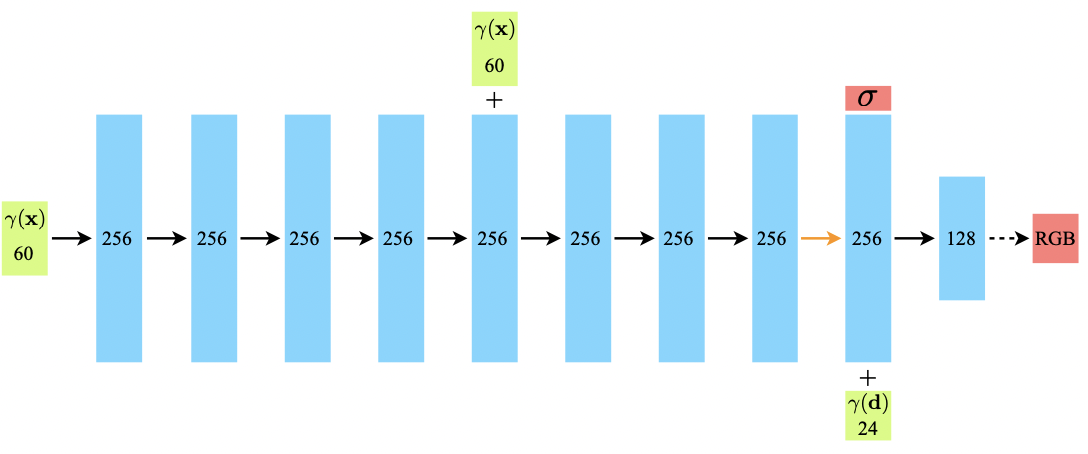

In [ ]:
class NeRF(torch.nn.Module):
  def __init__(self, gamma_x_dim=60, gamma_d_dim=24, num_channels=256, num_layers=8, skip=4):
    super(NeRF, self).__init__()

    self.layers = []
    for i in range(num_layers):
      if i == 0:
        self.layers.append(torch.nn.Linear(gamma_x_dim, num_channels))
      elif not i == skip:
        self.layers.append(torch.nn.Linear(num_channels, num_channels))
      else: 
        self.layers.append(torch.nn.Linear(num_channels + gamma_x_dim, num_channels))
    self.layers = torch.nn.ModuleList(self.layers)
    self.sigma_out = torch.nn.Linear(num_channels, 1)

    self.feature = torch.nn.Linear(num_channels, num_channels)
    self.branch = torch.nn.Linear(num_channels + gamma_d_dim, num_channels // 2)
    self.rgb_out = torch.nn.Linear(num_channels // 2, 3)

    self.skip = skip
    self.relu = torch.nn.functional.relu
  
  def forward(self, x, d):
    out = x
    for i, l in enumerate(self.layers):
      if not i == self.skip:
        out = self.relu(self.layers[i](out))
      else:
        out = torch.concat([out, x], dim=-1)
        out = self.relu(self.layers[i](out))

    sigma = self.sigma_out(out)

    out = self.feature(out)
    out = torch.concat([out, d], dim=-1)
    out = self.relu(self.branch(out))
    color = self.rgb_out(out)

    return color, sigma

# Prepare dataset 



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = dataset['images']
poses = dataset['poses']
focal_length = dataset['focal']

num_images, h, w = images.shape[:3]
test_idx = 101
test_image = images[test_idx]
test_pose = poses[test_idx]

images = torch.from_numpy(images[:100, ... ,:3]).to(device)
poses = torch.from_numpy(poses).to(device)
focal_length = torch.from_numpy(focal_length).to(device)

# Training

### 1. define hyperparameters

In [ ]:
L_x = 10
L_d = 4

N_c = 32

lr = 5e-4
num_iters = 10000
num_channels = 128
num_layers = 8
skip = 4

display_every = 1000

near = 2. 
far = 6. 

batch_size = 4 * 1024

include_input = True

### 2. Implement single training iteration 

In [ ]:
def train_step(h, w, focal_length, pose, near, far, n_c, L_c, L_d):

  rays_o, rays_d = get_rays(h, w, focal_length, pose)

  x, t = stratified_sampling(rays_o, rays_d, near, far, n_c)

  # (width, height, n_c, 3)
  # (widht * height * n_c, 3)
  x_flatten = x.reshape(-1, 3)
  d_flatten = rays_d[..., None, :].expand_as(x).reshape(-1, 3)

  gamma_x = positional_encoding(x_flatten, L_x, include_input)
  gamma_d = positional_encoding(d_flatten, L_d, include_input)
  
  pred = []
  for i in range(0, gamma_x.shape[0], batch_size):
    pred.append(model(gamma_x[i:i+batch_size], gamma_d[i:i+batch_size]))

  colors = torch.concat([p[0] for p in pred], dim=0).reshape(h, w, -1, 3)
  sigma = torch.concat([p[1] for p in pred], dim=0).reshape(h, w, -1, 1)
  
  rgb = volume_rendering(colors, sigma, rays_o, t)
  return rgb

### 3. Start training

In [ ]:
gamma_x_dim = 3 * 2 * L_x + (3 if include_input else 0)
gamma_d_dim = 3 * 2 * L_d + (3 if include_input else 0)
model = NeRF(gamma_x_dim, gamma_d_dim, num_channels, num_layers, skip)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

pbar = tqdm(range(num_iters))
for i in pbar:
  idx = np.random.randint(images.shape[0])
  image_i = images[idx]
  pose_i = poses[idx]

  rgb_predicted = train_step(h, w, focal_length, pose_i, near, far, N_c, L_x, L_d)
  
  loss = torch.nn.functional.mse_loss(rgb_predicted, image_i)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  pbar.set_postfix({"loss": loss.item()})

  if i % display_every == 0:
    rgb_predicted = train_step(h, w, focal_length, torch.from_numpy(test_pose).to(device), near, far, N_c, L_x, L_d)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())

    plt.subplot(122)
    plt.imshow(test_image)
    plt.title(f"Iteration {i}")
    plt.show()